<a href="https://colab.research.google.com/github/Yaojiameng/Lab1/blob/master/Binary_classification_of_quantum_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow==2.3.1
!pip install qutip
!pip install tensorflow-quantum

     |████████████████████████████████| 320.4MB 43kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 3.4MB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for qutip: filename=qutip-4.5.2-cp36-cp36m-linux_x86_64.whl size=12467995 sha256=bb72c8227c72c2ae0647cdf603458b2ba8d4b10525ba4403d574c435de42427e
  Stored in directory: /root/.cache/pip/wheels/ae/90/e9/f26fdecfb6c0e9d9d6f5fa564d16d26ff2bdfd8ad6e7a8a28a
Successfully built qutip
     |████████████████████████████████| 5.9MB 3.8MB/s 
     |████████████████████████████████| 5.6MB 22.8MB/s 
     |████████████████████████████████| 1.6MB 30.8MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [2]:
import cirq
import numpy as np
import qutip
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [3]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  q_data = []
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  for _ in range(num_samples):
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"
    labels.append(label)
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), cirq.rx(-spread_x)(qubit)))
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

In [4]:
qubit = cirq.GridQubit(0, 0)
theta_a = 1
theta_b = 4
num_samples = 200
q_data, labels, bloch_p = generate_dataset(qubit, theta_a, theta_b, num_samples)

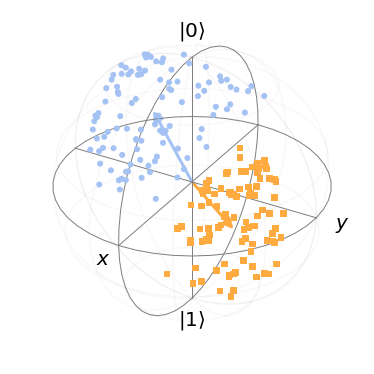

In [5]:
bloch = qutip.Bloch()
bloch.sphere_alpha = 0.0
bloch.frame_alpha = 0.05
bloch.vector_color[0] = bloch.point_color[0] = "#a4c2f4ff"
bloch.vector_color[1] = bloch.point_color[1] = "#ffab40ff"
bloch.add_points(bloch_p["a"])
bloch.add_points(bloch_p["b"])
vec = [[np.cos(theta_a),0,np.sin(theta_a)]]
bloch.add_vectors(vec)
vec = [[np.cos(theta_b),0,np.sin(theta_b)]]
bloch.add_vectors(vec)
bloch.show()

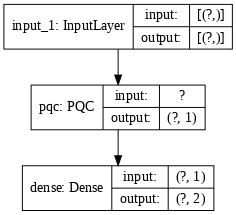

In [6]:
# Build the quantum model layer
theta = sympy.Symbol('theta')
q_model = cirq.Circuit(cirq.ry(theta)(qubit))
q_data_input = tf.keras.Input(
    shape=(), dtype=tf.dtypes.string)
expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
expectation_output = expectation(q_data_input)

# Attach the classical SoftMax classifier
classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
classifier_output = classifier(expectation_output)
model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

# Standard compilation for classification
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy())
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [7]:
history = model.fit(x=q_data, y=labels, epochs=50, verbose=0)

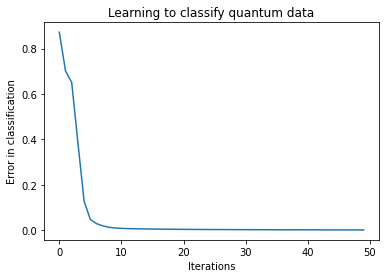

Final loss value:
0.0012292200699448586


In [8]:
plt.plot(history.history['loss'])
plt.title("Learning to classify quantum data")
plt.xlabel("Iterations")
plt.ylabel("Error in classification")
plt.show()
print("Final loss value:")
print(history.history["loss"][-1])

In [9]:
test_data, _, _ = generate_dataset(qubit, theta_a, theta_b, 1)
p = model.predict(test_data)[0]
print(f"prob(a)={p[0]:.4f}, prob(b)={p[1]:.4f}")

prob(a)=0.0008, prob(b)=0.9992
